<a href="https://colab.research.google.com/github/MayaHayat/Intel_Classification/blob/main/Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intel Image Classification

By Aviya Oren and Maya Hayat

This Data contains around 25k images of size 150x150 distributed under 6 categories.
1. 'buildings'
2. 'forest'
3. 'glacier'
4. 'mountain'
5. 'sea'
6. 'street'

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import random

import cv2
import imghdr
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

C:\Users\avoav\AppData\Local\Temp\ipykernel_84600\3969817906.py:19: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


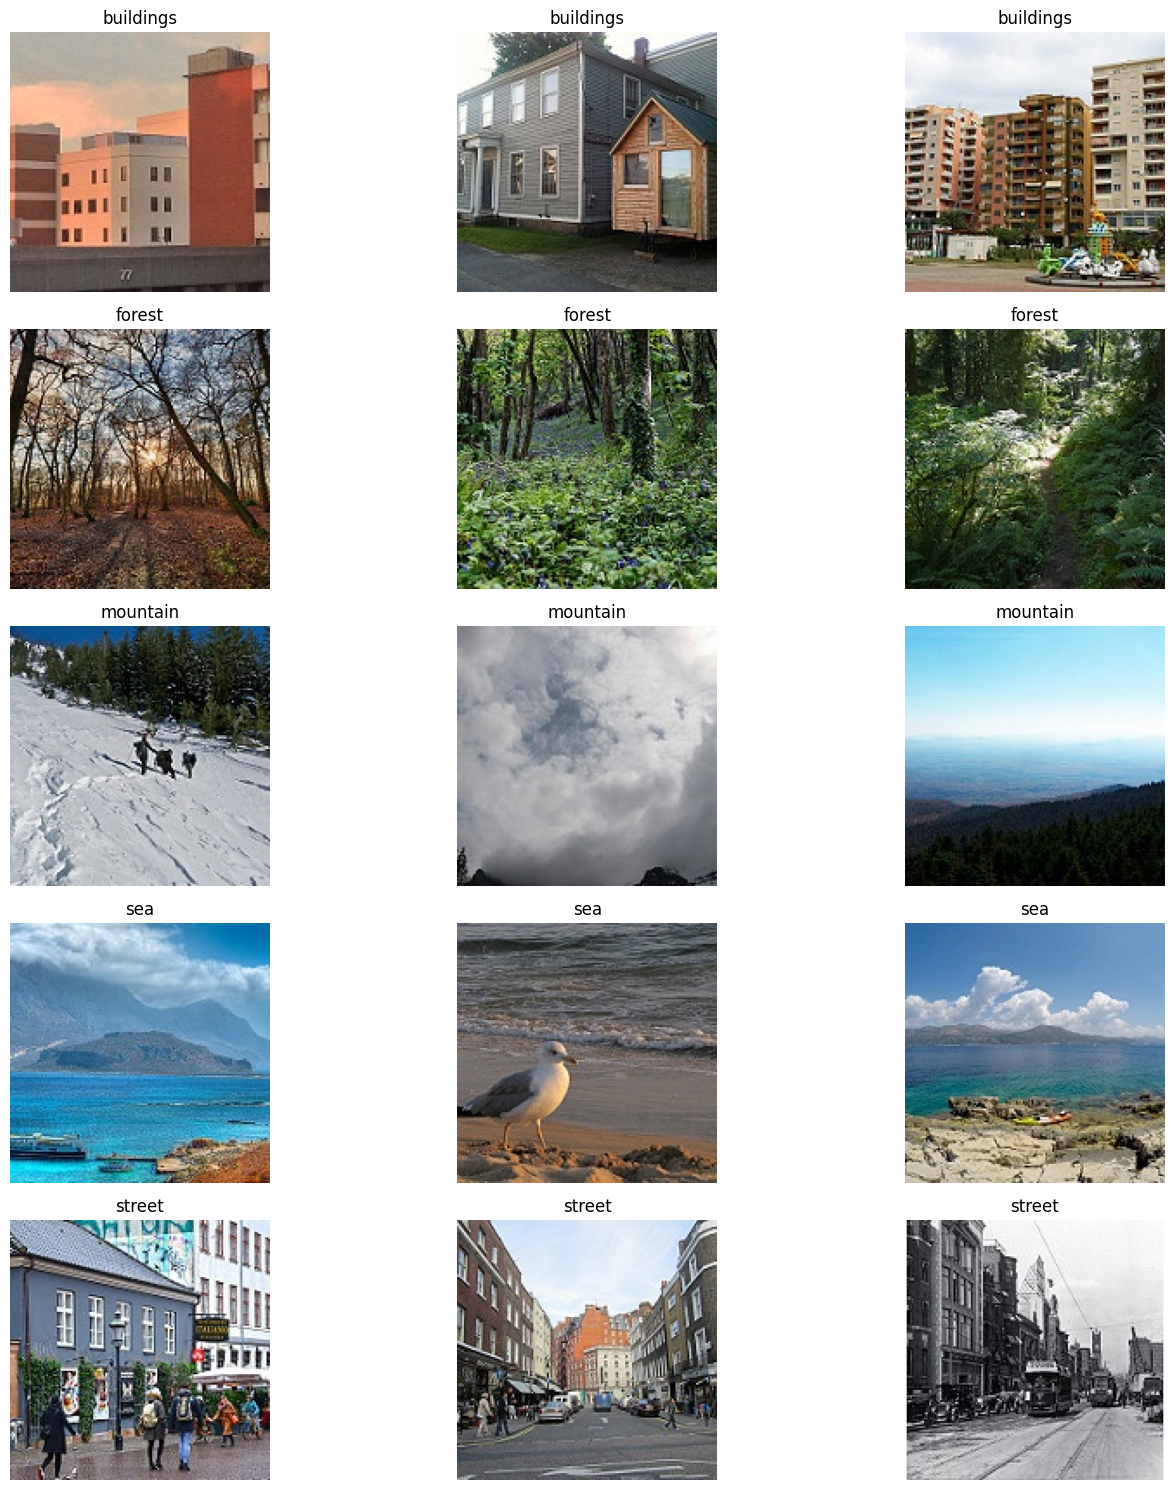

In [65]:
# Path to the directory containing the images
base_directory = 'C:/Users/avoav/OneDrive - Ariel University/year 3/NLP/seg_train/seg_train'

# Categories
categories = ['buildings', 'forest', 'mountain', 'sea', 'street']

# Display three random images for each category
fig, axs = plt.subplots(len(categories), 3, figsize=(15, 15))

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    random_images = random.sample(image_files, 3)

    for j, image_file in enumerate(random_images):
        image_path = os.path.join(category_directory, image_file)
        image = mpimg.imread(image_path)
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        axs[i, j].set_title(category)

plt.tight_layout()
plt.show()


In [24]:
data_directory = 'C:/Users/avoav/OneDrive - Ariel University/year 3/NLP/seg_train/seg_train'

In [107]:
test_data = 'C:/Users/avoav/OneDrive - Ariel University/year 3/NLP/seg_test/seg_test'

In [75]:
os.listdir(data_directory)

['buildings', 'forest', 'mountain', 'sea', 'street']

In [76]:
os.listdir(test_data)

['buildings', 'forest', 'mountain', 'sea', 'street']

In [77]:
# According to Kaggle the original size if 150*150, therefore we want to keep it as is
data = tf.keras.utils.image_dataset_from_directory(data_directory, image_size = (150,150), batch_size=128)

Found 11630 files belonging to 5 classes.


In [108]:
test = tf.keras.utils.image_dataset_from_directory(test_data, image_size = (150,150), batch_size=128)

Found 2447 files belonging to 5 classes.


In [79]:
data_iterator = data.as_numpy_iterator()
test_iterator = test.as_numpy_iterator()

In [80]:
batch = data_iterator.next()

In [81]:
batch_test = test_iterator.next()

In [82]:
# where the first batch is our data and the second is the labels
len(batch),len(batch_test)

(2, 2)

In [83]:
batch[0].shape

(128, 150, 150, 3)

In [84]:
batch_test[0].shape

(128, 150, 150, 3)

In [85]:
batch[1]

array([0, 0, 1, 4, 2, 2, 0, 0, 3, 2, 4, 4, 3, 2, 0, 1, 2, 4, 3, 2, 3, 2,
       3, 2, 0, 3, 4, 3, 4, 4, 0, 0, 4, 3, 2, 3, 2, 4, 0, 1, 1, 1, 1, 4,
       4, 4, 3, 4, 0, 3, 4, 3, 3, 3, 2, 3, 2, 2, 2, 3, 4, 1, 1, 4, 0, 2,
       4, 0, 1, 1, 2, 0, 2, 3, 4, 4, 4, 3, 1, 1, 1, 4, 2, 2, 2, 3, 0, 2,
       2, 0, 3, 1, 0, 1, 0, 2, 3, 2, 3, 0, 1, 4, 4, 4, 3, 2, 2, 2, 0, 1,
       1, 0, 2, 1, 1, 3, 1, 3, 2, 1, 2, 2, 2, 4, 3, 4, 4, 4])

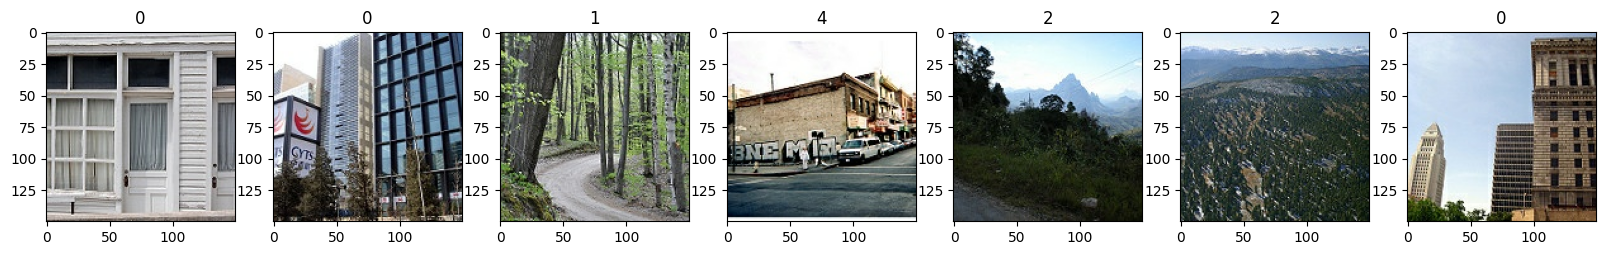

In [86]:
fig, ax = plt.subplots(ncols=7, figsize=(20,20))
for idx, img in enumerate(batch[0][:7]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

As we can see above the following numbers match the following catagories:

0. building
1. forest
2. mountain
3. sea
4. street

In [87]:
print("max:" , batch[0].max(), " and min: ", batch[0].min())

max: 255.0  and min:  0.0


In [88]:
data = data.map(lambda x, y: (x / 255.0, y))

In [109]:
test = test.map(lambda x, y: (x / 255.0, y))

In [90]:
data.as_numpy_iterator().next()[0].max(), data.as_numpy_iterator().next()[0].min()

(1.0, 0.0)

In [91]:
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.2)

In [92]:
print(train_size, val_size)

72 18


In [93]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)

In [94]:
# Number of batches * 32 images
len(train), len(val), len(test)

(72, 18, 20)

In [41]:
model= tf.keras.Sequential([
    # First layer
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # Second layer
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Third layer
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [42]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 17, 17, 64)       

In [57]:
logdir = 'logs'

In [58]:
callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [46]:
history = model.fit(train, epochs=20, validation_data = val, callbacks=[callback])

Epoch 1/20
88/88 [==============================] - 1509s 17s/step - loss: 1.1800 - accuracy: 0.5382 - val_loss: 0.9256 - val_accuracy: 0.6495
Epoch 2/20
88/88 [==============================] - 622s 7s/step - loss: 0.8203 - accuracy: 0.6931 - val_loss: 0.7644 - val_accuracy: 0.7148
Epoch 3/20
88/88 [==============================] - 548s 6s/step - loss: 0.6574 - accuracy: 0.7583 - val_loss: 0.8163 - val_accuracy: 0.6917
Epoch 4/20
88/88 [==============================] - 546s 6s/step - loss: 0.5559 - accuracy: 0.8000 - val_loss: 0.6145 - val_accuracy: 0.7744
Epoch 5/20
88/88 [==============================] - 550s 6s/step - loss: 0.4655 - accuracy: 0.8308 - val_loss: 0.5419 - val_accuracy: 0.8119
Epoch 6/20
88/88 [==============================] - 607s 7s/step - loss: 0.3961 - accuracy: 0.8573 - val_loss: 0.5389 - val_accuracy: 0.8090
Epoch 7/20
88/88 [==============================] - 549s 6s/step - loss: 0.3366 - accuracy: 0.8775 - val_loss: 0.5116 - val_accuracy: 0.8199
Epoch 8/20


In [47]:
model.save('best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the saved model
#loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/IntelClassification/first_model_8epc.h5')

In [ ]:
# Compile the loaded model
#loaded_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# Train the loaded model
#history = loaded_model.fit(train_images_norm, train_labels, epochs=8, validation_data=(val_images_norm, val_labels), callbacks=[callback])


In [38]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

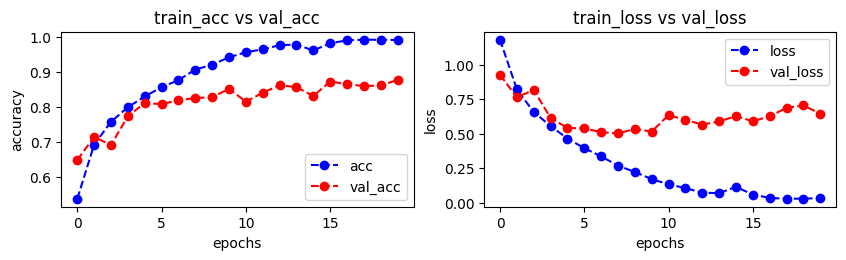

In [49]:
plot_accuracy_loss(history)

In [52]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    acc.update_state(y, y_pred)

3/3 [==============================] - 1s 204ms/step


In [53]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9672, Recall: 0.9499, Accuracy:0.6667


# VGG Model

In [110]:
# According to Kaggle the original size if 150*150, therefore we want to keep it as is
data_whole_5_batches = tf.keras.utils.image_dataset_from_directory(base_directory, image_size = (150,150), batch_size=2326)

Found 11630 files belonging to 5 classes.


In [111]:
data_whole_5_batches = data_whole_5_batches.map(lambda x, y: (x / 255.0, y))

In [ ]:
logdir = 'logs'

In [55]:
callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

NameError: name 'logdir' is not defined

In [53]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# # Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the head model
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(6, activation='softmax')(x) 

model_vgg_k_fold = Model(inputs=base_model.input, outputs=output)
model_vgg_k_fold.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [60]:
# Assume model is defined and compiled
for val_idx, val_batch in enumerate(data_whole_5_batches.as_numpy_iterator()):
    if val_idx == 0:
        print(f"Validation Batch Index: {val_idx}")
        X_val, y_val = val_batch
        print(y_val)
        print("----------------------------------------------------------------------")
        continue

    train_features_all = []
    train_labels_all = []
    for i, train_batch in enumerate(data_whole_5_batches.as_numpy_iterator()):
        if i != val_idx:
            train_features_all.append(train_batch[0])
            train_labels_all.append(train_batch[1])
    
    train_features_all = np.concatenate(train_features_all, axis=0)
    train_labels_all = np.concatenate(train_labels_all, axis=0)

    # Train the model on all 4 batches
    history_vgg_k_fold = model_vgg_k_fold.fit(train_features_all, train_labels_all, batch_size=128, epochs=3, validation_data=(X_val, y_val), callbacks=[callback])
    all_histories.append(history_vgg_k_fold)

Validation Batch Index: 0
[3 3 1 ... 1 3 4]
----------------------------------------------------------------------
Epoch 1/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 1432s 20s/step - accuracy: 0.7200 - loss: 0.7253 - val_accuracy: 0.9183 - val_loss: 0.2074
Epoch 2/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 1406s 19s/step - accuracy: 0.9333 - loss: 0.1787 - val_accuracy: 0.9441 - val_loss: 0.1629
Epoch 3/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 1374s 19s/step - accuracy: 0.9529 - loss: 0.1359 - val_accuracy: 0.9635 - val_loss: 0.1150
Epoch 4/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 1422s 20s/step - accuracy: 0.9619 - loss: 0.1060 - val_accuracy: 0.9686 - val_loss: 0.1104
Epoch 5/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 1376s 19s/step - accuracy: 0.9725 - loss: 0.0824 - val_accuracy: 0.9802 - val_loss: 0.0811


NameError: name 'all_histories' is not defined

In [73]:
model_vgg_k_fold.save('C:/Users/avoav/OneDrive - Ariel University/year 3/NLP/vgg_model.h5')

In [100]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

y_true_all = []
y_pred_all = []

for batch in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg_k_fold.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 6)
    acc.update_state(y_true_one_hot, yhat)
    y_true_all = np.concatenate([y_true_all, y])
    y_pred_all = np.concatenate([y_pred_all, y_pred])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [101]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 1.0000, Recall: 1.0000, Accuracy:0.9333


In [112]:
model_vgg_k_fold_2= tf.keras.models.load_model(r'C:/Users/avoav/OneDrive - Ariel University/year 3/NLP/vgg_model.h5')

In [114]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

y_true_all = []
y_pred_all = []

for batch_test in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg_k_fold_2.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 6)
    acc.update_state(y_true_one_hot, yhat)
    y_true_all = np.concatenate([y_true_all, y])
    y_pred_all = np.concatenate([y_pred_all, y_pred])

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [115]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9748, Recall: 0.9826, Accuracy:0.9268


In [102]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model_vgg_k_fold.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 266s 13s/step - accuracy: 0.9247 - loss: 0.2086
Test Loss: 0.19973304867744446, Test Accuracy: 0.9268491864204407


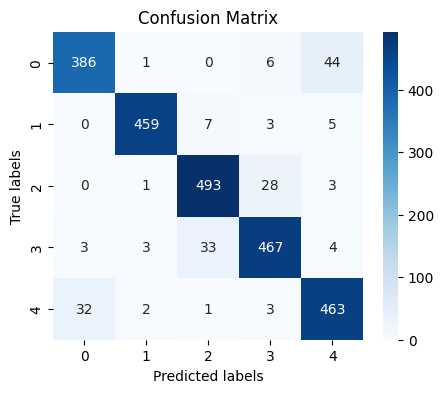

In [116]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

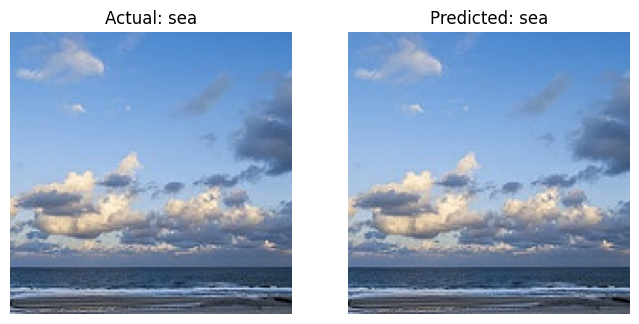

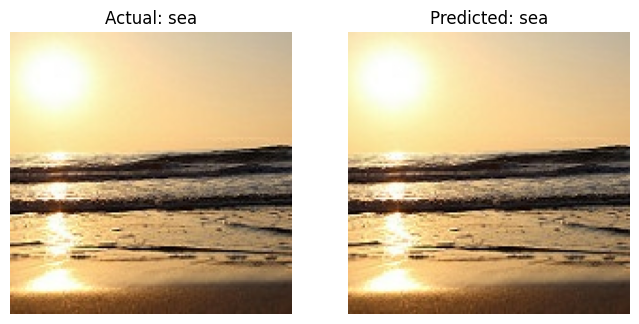

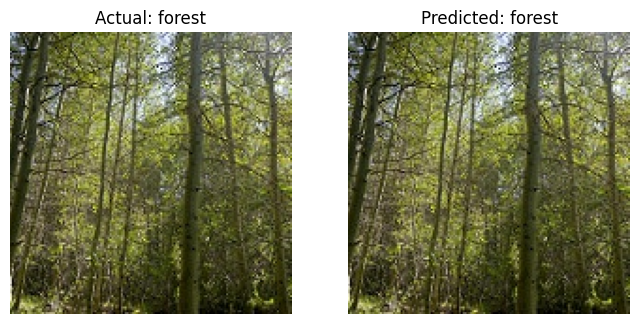

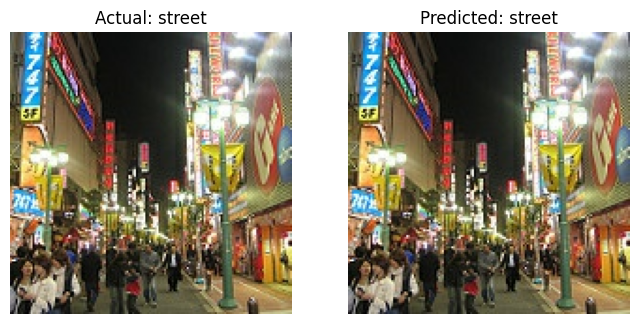

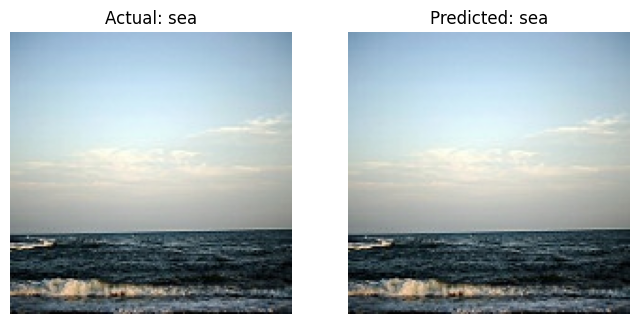

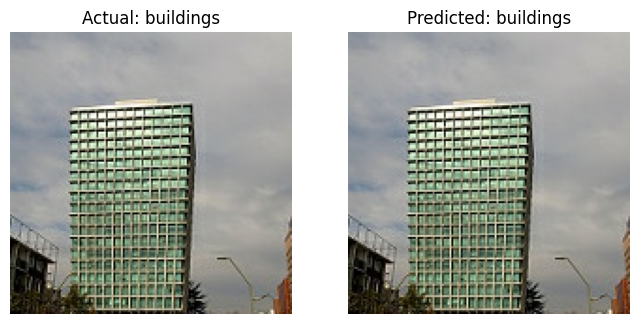

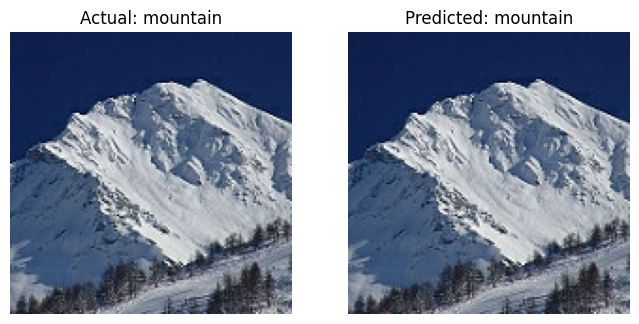

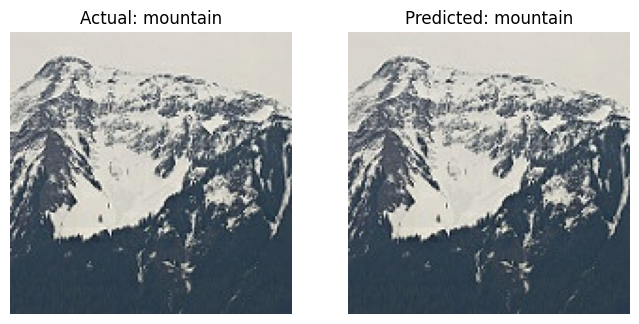

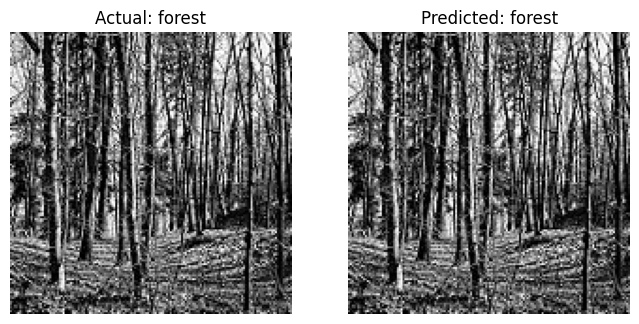

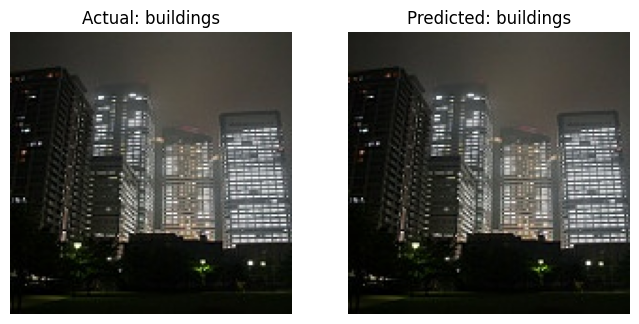

In [69]:

# Select the first 10 samples from the validation set for visualization
sample_indices = range(10)

for index in sample_indices:
    plt.figure(figsize=(8, 4))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(X_val[index])
    true_label = categories[int(y_val[index])]  # Convert to integer for indexing
    plt.title(f"Actual: {true_label}")
    plt.axis('off')

    # Display the model's prediction
    plt.subplot(1, 2, 2)
    predicted_class = np.argmax(predictions[index])
    predicted_label = categories[predicted_class]
    plt.imshow(X_val[index])
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')

    plt.show()

In [72]:
correct_predictions = 0

# Iterate through the entire validation set
for index in range(len(X_test)):
    predicted_class = np.argmax(predictions[index])
    true_class = int(y_val[index])

    # Check if the prediction is correct
    if predicted_class == true_class:
        correct_predictions += 1

# Print the accuracy
print("all samples: " ,len(X_test))
print("correct_predictions:" ,correct_predictions)
accuracy = correct_predictions / len(X_test)
print(f"Accuracy: {accuracy * 100:.2f}%")


all samples:  2326
correct_predictions: 2280
Accuracy: 98.02%


In [ ]:
##### ===================== something else:

In [47]:
from tensorflow.keras.applications import VGG16
model_vgg = VGG16(weights='imagenet', include_top = False, input_shape=(150, 150, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [48]:
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

# Instantiate EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

# Use the callback during model training
history_vgg = model_vgg.fit(train, epochs=3, validation_data=val, callbacks=[early_stopping_callback])


Epoch 1/3


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None,), output.shape=(None, 4, 4, 512)

In [41]:
model_vgg.save('vgg_model.h5')

In [ ]:
plt.plot(history_vgg.history["accuracy"])
plt.plot(history_vgg.history['val_accuracy'])
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

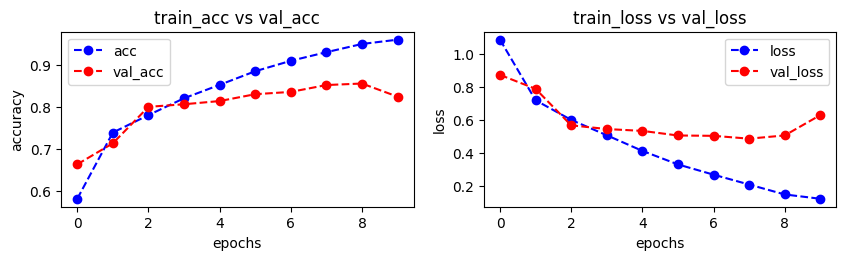

In [39]:
plot_accuracy_loss(history_vgg)

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model_vgg.predict(X, batch_size=128)
    # print(y.shape, yhat.shape)
    # break
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    acc.update_state(y, y_pred)

1/1 [==============================] - 1s 1s/step


In [ ]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre_test = Precision()
re_test = Recall()
acc_test = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg.predict(X, batch_size=128)
    # print(y.shape, yhat.shape)
    # break
    y_pred = np.argmax(yhat,axis=1)
    pre_test.update_state(y, y_pred)
    re_test.update_state(y, y_pred)
    acc_test.update_state(y, y_pred)

In [31]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model_vgg.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")


ValueError: The last dimension of the inputs to a Dense layer should be defined. Found None. Full input shape received: (None, None)